In [43]:
import numpy as np
import scipy
from sklearn.datasets import make_circles
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kernel_pca as kpca # python file of own implementation of kernel PCA
from sklearn.metrics import mean_squared_error

In [44]:
X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

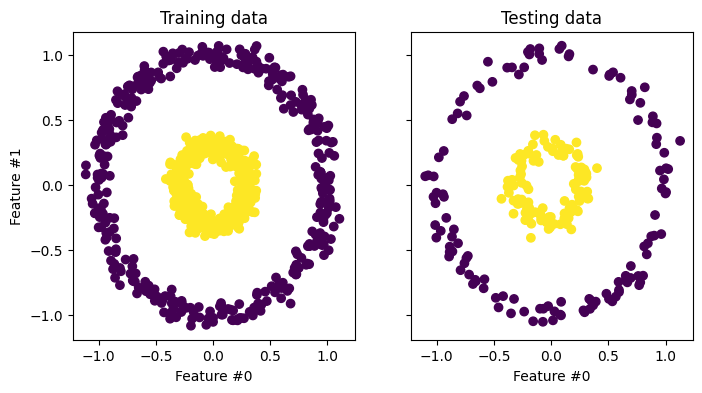

In [45]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

# Own implementation

In [46]:
X_transformed_kernel_pca, eigenvectors, eigenvalues = kpca.kernel_PCA(X_train, X_test, n_components=None, kernel='rbf', gamma=10, mode='transform')
X_recon_kernel_pca, X_recon_kernel_pca_err = kpca.kernel_PCA(X_train, X_test, n_components=None, kernel='rbf', gamma=10, mode='recon', alpha=0.1)

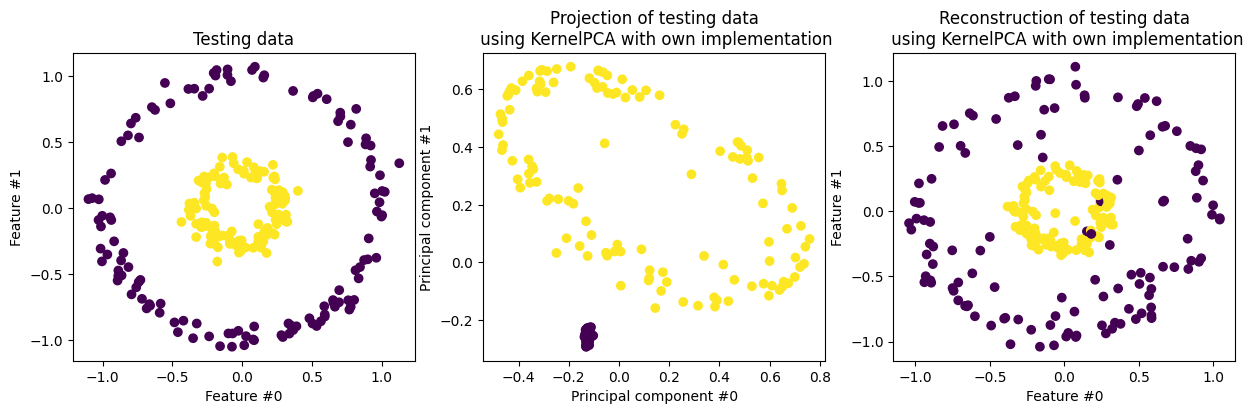

In [47]:
fig, (orig_data_ax, kernel_pca_proj_ax, kernel_pca_recon_ax) = plt.subplots(
    ncols=3, figsize=(15, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Testing data")

kernel_pca_proj_ax.scatter(X_transformed_kernel_pca[:, 0], X_transformed_kernel_pca[:, 1], c=y_test)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA with own implementation")

kernel_pca_recon_ax.scatter(X_recon_kernel_pca[:, 0], X_recon_kernel_pca[:, 1], c=y_test)
kernel_pca_recon_ax.set_ylabel("Feature #1")
kernel_pca_recon_ax.set_xlabel("Feature #0")
_ = kernel_pca_recon_ax.set_title("Reconstruction of testing data\n using KernelPCA with own implementation")

# Compare to the results taken from sklearn example
https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html#sphx-glr-auto-examples-decomposition-plot-kernel-pca-py

In [48]:
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=10, eigen_solver='dense', fit_inverse_transform=True, alpha=0.1)
X_kernel_pca_sklearn = kernel_pca.fit(X_train).transform(X_test)
X_recon_kernel_pca_sklearn = kernel_pca.inverse_transform(X_kernel_pca_sklearn)

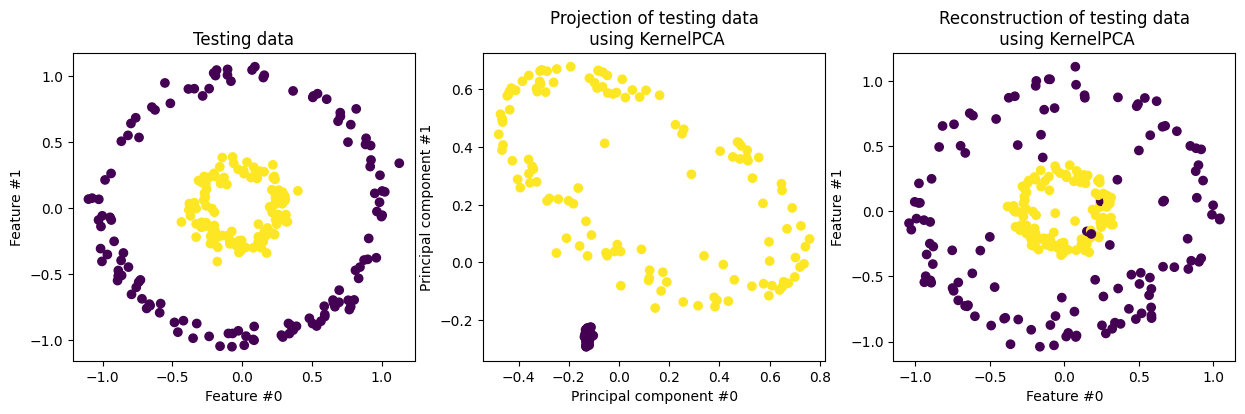

In [49]:
fig, (orig_data_ax, kernel_pca_proj_ax, kernel_pca_recon_ax) = plt.subplots(
    ncols=3, figsize=(15, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Testing data")

kernel_pca_proj_ax.scatter(X_kernel_pca_sklearn[:, 0], X_kernel_pca_sklearn[:, 1], c=y_test)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

kernel_pca_recon_ax.scatter(X_recon_kernel_pca_sklearn[:, 0], X_recon_kernel_pca_sklearn[:, 1], c=y_test)
kernel_pca_recon_ax.set_ylabel("Feature #1")
kernel_pca_recon_ax.set_xlabel("Feature #0")
_ = kernel_pca_recon_ax.set_title("Reconstruction of testing data\n using KernelPCA")

# Results reproduced perfectly! :D

In [50]:
print(f"Own implementation\n{eigenvectors}")
print(f"sklearn\n{kernel_pca.eigenvectors_}")

Own implementation
[[-0.01342917 -0.03042237 -0.01549663 ... -0.         -0.
   0.        ]
 [ 0.08369597  0.00560315  0.01514663 ... -0.00590524 -0.01639696
  -0.01231157]
 [ 0.05540546 -0.0120412   0.05936189 ...  0.00883146  0.00352819
  -0.019962  ]
 ...
 [ 0.04246709 -0.01753123  0.05499112 ...  0.00712595  0.0142801
  -0.01275347]
 [-0.01435269 -0.02794657 -0.01315284 ...  0.0046077  -0.02148564
  -0.01185784]
 [-0.0144879  -0.02851109 -0.01610421 ... -0.0010564  -0.00079252
  -0.00175155]]
sklearn
[[-1.34291652e-02 -3.04223737e-02 -1.54966288e-02 ...  4.46355034e-02
  -1.64047728e-02 -1.58099591e-02]
 [ 8.36959670e-02  5.60315467e-03  1.51466321e-02 ...  2.66508777e-02
  -2.23595268e-05 -2.97256567e-02]
 [ 5.54054568e-02 -1.20412004e-02  5.93618869e-02 ... -2.37475363e-02
   8.90251622e-03  6.38238263e-03]
 ...
 [ 4.24670950e-02 -1.75312252e-02  5.49911155e-02 ...  8.27787652e-02
  -5.77694839e-03  4.36884185e-02]
 [-1.43526907e-02 -2.79465733e-02 -1.31528429e-02 ...  1.38378692

## Below is my failed atttempt to reproduce the toy example result in the OG https://alex.smola.org/papers/1999/MikSchSmoMuletal99.pdf, apparently the algorithm for reproducing this result is more complex than I thought. You could take a look at the iterative algorithm in the paper. Have given up on this and changed the code back to the one that reproduce the above sklearn example, so the below code don't work.

In [34]:
N = 10  # Sample space dimension
M = 11  #  Number of Gaussians
S = [100, 33]  #  Samples selected from each source for [training, test]
std_list = [0.05, 0.1, 0.2, 0.4, 0.8]
n_components = 1
for std in std_list:
    c = 2*std**2

    # Pick centers of the M Gaussians
    centers = np.random.uniform(low=-1.0, high=1.0, size=(M, N))  # M x N

    # Construct train_data as a matrix of dimension (S[0]*M) x N, that is S[0] samples for each Gaussian. Each row of the matrix is an N-dimensional sample
    train_data = np.random.multivariate_normal(mean=centers[0], cov=std ** 2 * np.eye(N), size=S[0])
    for i in range(1, M):
        train_data = np.concatenate((train_data, np.random.multivariate_normal(mean=centers[i], cov=std ** 2 * np.eye(N), size=S[0])), axis=0)  
    
    # Construct test_data as a matrix of dimension (S[1]*M) x N, that is S[0] samples for each Gaussian. Each row of the matrix is an N-dimensional sample
    test_data = np.random.multivariate_normal(mean=centers[0], cov=std ** 2 * np.eye(N), size=S[1])
    for i in range(1, M):
        test_data = np.concatenate((test_data, np.random.multivariate_normal(mean=centers[i], cov=std ** 2 * np.eye(N), size=S[1])), axis=0)  


    # kernel_pca = KernelPCA(n_components=n_components, kernel="rbf", gamma=1/(N*c), eigen_solver='dense', fit_inverse_transform=True)
    # kpca_test_transformed = kernel_pca.fit(train_data).transform(test_data)
    # kpca_test_recon = kernel_pca.inverse_transform(kpca_test_transformed)
    # recon_err_kpca = mean_squared_error(test_data, kpca_test_recon)
    recon_err_kpca = kpca.kernel_PCA(train_data, test_data, n_components, 'rbf', 1/(N*c), c, 'recon')
    print(f'Kernel PCA: sigma = {std}, err = {recon_err_kpca}')

    pca = PCA(n_components)
    pca_transformed_test = pca.fit(train_data).transform(test_data)
    pca_recon_test = pca.inverse_transform(pca_transformed_test)
    recon_err_pca = mean_squared_error(test_data, pca_recon_test)
    print(f'Linear PCA: err = {recon_err_pca}')
    


Kernel PCA: sigma = 0.05, err = None
Linear PCA: err = 0.19945464199869026
Kernel PCA: sigma = 0.1, err = None
Linear PCA: err = 0.16109775559060807
Kernel PCA: sigma = 0.2, err = None
Linear PCA: err = 0.2570209108858249
Kernel PCA: sigma = 0.4, err = None
Linear PCA: err = 0.3847604164608371
Kernel PCA: sigma = 0.8, err = None
Linear PCA: err = 0.8158545638879346
